In [1]:
# 导入工具库
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

plt.rcParams['font.sans-serif'] = ['FangSong']  # 设置中文为仿宋
plt.rcParams['font.family'] = 'Times New Roman'  # 设置英文为 Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 确保负号显示正常

In [2]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 将图像统一调整为28x28
    transforms.ToTensor()
])
train_data = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='../data', train=False, transform=transform)

In [3]:
class Args:
   def __init__(self):
       self.train_acc = []
       self.test_acc = []
       self.train_loss = []
       self.test_loss = []
       self.epochs = 10
       self.batch_size = 32
       self.num_class = 11
       self.learn_rate = 0.01
       self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Args()

In [4]:
train_dataloader = DataLoader(train_data, batch_size=args.batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

In [5]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 1, 28, 28])

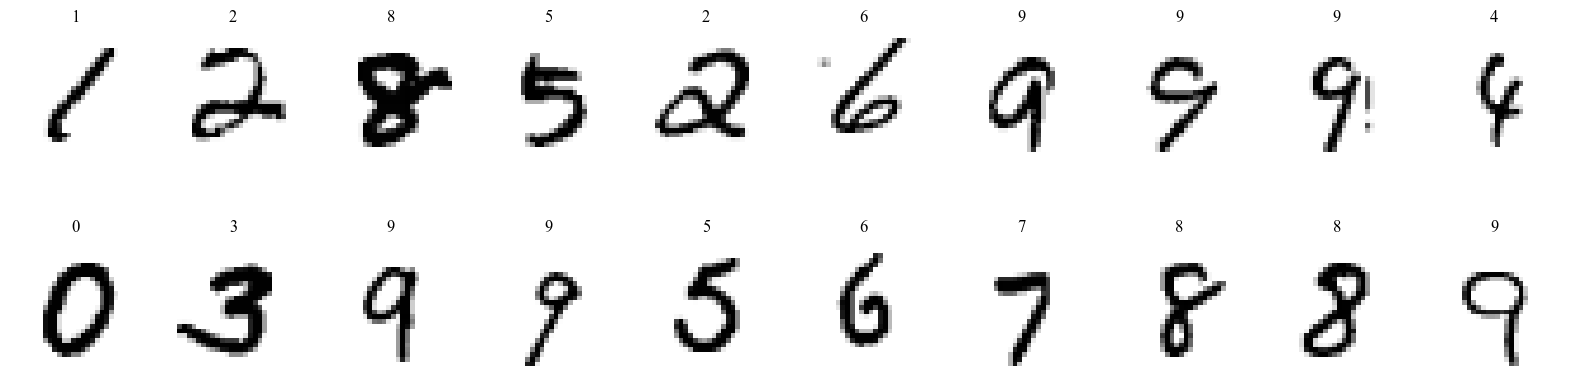

In [6]:
plt.figure(figsize=(20, 5))
for i, img in enumerate(img[:20]):
    nping = np.squeeze(img.numpy())
    plt.subplot(2, 10, i+1)
    plt.imshow(nping, cmap=plt.cm.binary)
    plt.title(f"{label[i]}")
    plt.axis('off')
plt.show()

In [7]:
class CNN(nn.Module):
    def __init__(self, class_num):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(in_features=1600, out_features=64)
        self.output = nn.Linear(in_features=64, out_features=class_num)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.linear(x))
        x = self.output(x)
        
        return x

In [8]:
model = CNN(args.num_class).to(args.device)
print(summary(model,input_size=(1, 28, 28),batch_dim=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─Conv2d: 1-3                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-4                         [1, 64, 5, 5]             --
├─Flatten: 1-5                           [1, 1600]                 --
├─Linear: 1-6                            [1, 64]                   102,464
├─Linear: 1-7                            [1, 11]                   715
Total params: 121,995
Trainable params: 121,995
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.49
Estimated Total Size (MB): 0.73


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.learn_rate)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    
    train_loss, train_acc = 0, 0
    
    for X, y in dataloader:
        X, y = X.to(args.device), y.to(args.device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
    
    train_acc /= size
    train_loss /= num_batch
    
    return train_acc, train_loss

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    
    test_loss, test_acc = 0, 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(args.device), labels.to(args.device)
            
            label_pred = model(images)
            loss = loss_fn(label_pred, labels)
            
            test_acc += (label_pred.argmax(1) == labels).type(torch.float).sum().item()
            test_loss += loss.item()
        
        test_acc /= size
        test_loss /= num_batch
        
    return test_acc, test_loss

In [12]:
for epoch in range(args.epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dataloader, model, loss_fn)
    
    args.train_acc.append(epoch_train_acc)
    args.test_acc.append(epoch_test_acc)
    args.train_loss.append(epoch_train_loss)
    args.test_loss.append(epoch_test_loss)
    
    template = ("Epoch: {:2d}, Train_acc: {:.1f}%, Train_loss: {:.3f}, Test_acc: {:.1f}%, Test_loss: {:.3f}")
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print("Done")

Epoch:  1, Train_acc: 73.4%, Train_loss: 0.866, Test_acc: 92.9%, Test_loss: 0.236
Epoch:  2, Train_acc: 94.2%, Train_loss: 0.190, Test_acc: 96.2%, Test_loss: 0.124
Epoch:  3, Train_acc: 96.5%, Train_loss: 0.118, Test_acc: 96.8%, Test_loss: 0.102
Epoch:  4, Train_acc: 97.2%, Train_loss: 0.091, Test_acc: 97.7%, Test_loss: 0.076
Epoch:  5, Train_acc: 97.7%, Train_loss: 0.076, Test_acc: 97.6%, Test_loss: 0.073
Epoch:  6, Train_acc: 98.0%, Train_loss: 0.066, Test_acc: 98.4%, Test_loss: 0.053
Epoch:  7, Train_acc: 98.3%, Train_loss: 0.058, Test_acc: 98.3%, Test_loss: 0.054
Epoch:  8, Train_acc: 98.4%, Train_loss: 0.052, Test_acc: 98.3%, Test_loss: 0.049
Epoch:  9, Train_acc: 98.6%, Train_loss: 0.048, Test_acc: 98.5%, Test_loss: 0.046
Epoch: 10, Train_acc: 98.7%, Train_loss: 0.044, Test_acc: 98.4%, Test_loss: 0.045
Done


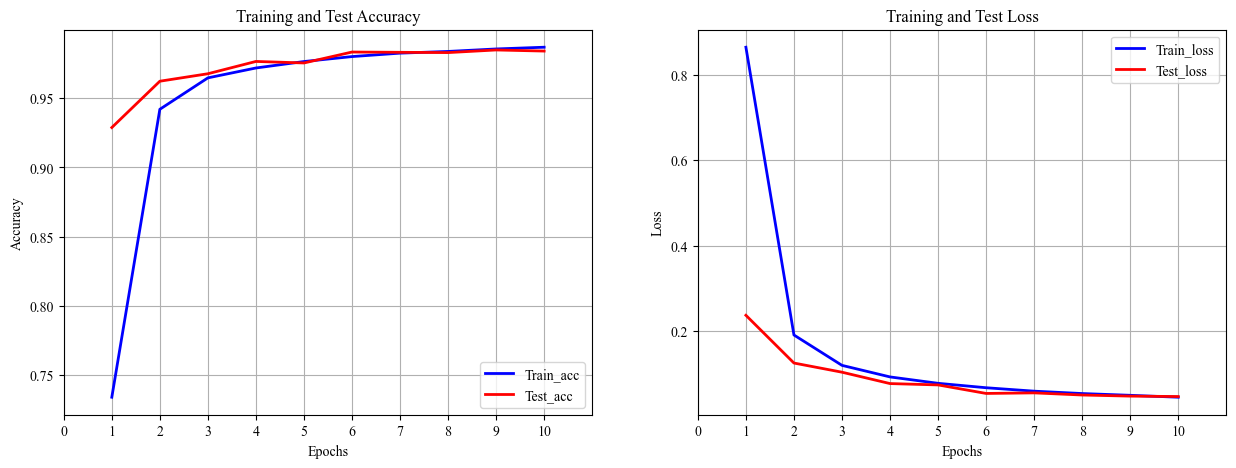

In [13]:
epoch_range = range(1,args.epochs+1)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epoch_range, args.train_acc,
         label='Train_acc',color='blue',linewidth = 2)
ax1.plot(epoch_range, args.test_acc,
         label='Test_acc',color='red',linewidth = 2)

ax1.set_title('Training and Test Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax1.legend(loc='best')

ax1.set_xlim(1,args.epochs+1)

x_ticks = np.arange(0,args.epochs+1)
ax1.set_xticks(x_ticks)
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epoch_range, args.train_loss,
         label='Train_loss',color='blue',linewidth = 2)
ax2.plot(epoch_range, args.test_loss,
         label='Test_loss',color='red',linewidth = 2)

ax2.set_title('Training and Test Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax2.legend(loc='best')

ax2.set_xlim(1,args.epochs+1)

x_ticks = np.arange(0,args.epochs+1)
ax2.set_xticks(x_ticks)
ax2.grid()

plt.savefig('../result/The_MNIST_Result.svg', format='svg')
plt.show()